# Penman-Monteith Sensitivity

## The function to run the 1-hour time-step Penman-Monteith equation from shyft

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
from shyft.time_series import (Calendar,deltahours,TimeSeries,TimeAxis,DoubleVector,point_interpretation_policy)
import shyft.hydrology as api


In [2]:
def run_pm(ws_Th, ws_eah, ws_Rsh, ws_windspeedh,ws_rhh, rnet, 
           height_veg=0.12,dt=1, n=30,rl = 144.0,height_ws = 3, 
           height_t = 1.68, elevation = 1462.4, method='asce-ewri'):
    """Run Penman-Monteith evapotranspiration model from SHyFT"""


    utc = Calendar()

    c_MJm2d2Wm2 = 0.086400
    c_MJm2h2Wm2 = 0.0036

    # n = 30 # nr of time steps: 1 year, daily data
    t_starth = utc.time(2000, 7, 1,16,0,0,0) # starting at 1-07-2000
    step = deltahours(dt)


    # Let's now create Shyft time series from the supplied lists of precipitation and temperature.
    # First, we need a time axis, which is defined by a starting time, a time step and the number of time steps.
    ta = TimeAxis(t_starth, step, n) # days

    # First, we convert the lists to shyft internal vectors of double values:
    temph_dv = DoubleVector.from_numpy(ws_Th)
    eah_dv = DoubleVector.from_numpy(ws_eah)
    rsh_dv = DoubleVector.from_numpy(ws_Rsh)
    windspeedh_dv = DoubleVector.from_numpy(ws_windspeedh)

    rhh_dv = DoubleVector.from_numpy(ws_rhh)

    # Finally, we create shyft time-series as follows:
    # (Note: This step is not necessarily required to run the single methods.
    #  We could also just work with the double vector objects and the time axis)
    instant = point_interpretation_policy.POINT_INSTANT_VALUE
    average = point_interpretation_policy.POINT_AVERAGE_VALUE

    temph_ts = TimeSeries(ta, temph_dv, point_fx=instant)
    eah_ts = TimeSeries(ta, eah_dv, point_fx=instant)
    rsh_ts = TimeSeries(ta, rsh_dv, point_fx=instant)
    windspeedh_ts = TimeSeries(ta, windspeedh_dv, point_fx=instant)

    #recalculated inputs:
    rhh_ts = TimeSeries(ta, rhh_dv, point_fx=instant)
    
    if method=='asce-ewri':
        full_model = False
    else:
        full_model = True
        
    pmph = api.PenmanMonteithParameter(height_veg,height_ws,height_t, rl, full_model)
    pmch = api.PenmanMonteithCalculator(pmph)
    pmrh = api.PenmanMonteithResponse()

    #PriestleyTaylor
    ptp = api.PriestleyTaylorParameter(0.2,1.26)
    ptc = api.PriestleyTaylorCalculator(0.2, 1.26)
    ptr = api.PriestleyTaylorResponse

    ET_ref_sim_h= []

    for i in range(n-1):
        pmch.reference_evapotranspiration(pmrh, step,rnet[i], temph_ts.v[i],temph_ts.v[i],
                                                      rhh_ts.v[i], elevation, windspeedh_ts.v[i])
        ET_ref_sim_h.append(pmrh.et_ref)


    return ET_ref_sim_h

## So this is our main code to study sensitivity

In [3]:

# Single method test based on ASCE-EWRI Appendix C, hourly time-step
latitude = 40.41
longitude = 104.78
elevation = 1462.4
height_ws = 3 # height of anemometer
height_t = 1.68 # height of air temperature and rhumidity measurements
surface_type = "irrigated grass"
height_veg = 0.12 #vegetation height
# height_veg = 0.5 #tall
atm_pres_mean = 85.17  # [kPa]
psychrom_const = 0.0566
windspeed_adj = 0.921

# Data from weather station
ws_Th = [30.9, 31.2, 29.1, 28.3, 26.0, 22.9, 20.1, 19.9, 18.4, 16.5, 15.4, 15.5, 13.5, 13.2, 16.2, 20.0, 22.9, 26.4,
         28.2, 29.8, 30.9, 31.8, 32.5, 32.9, 32.4, 30.2, 30.6, 28.3, 25.9, 23.9]
ws_eah = [1.09, 1.15, 1.21, 1.21, 1.13, 1.20, 1.35, 1.35, 1.32, 1.26, 1.34, 1.31, 1.26, 1.24, 1.31, 1.36, 1.39, 1.25,
          1.17, 1.03, 1.02, 0.98, 0.87, 0.86, 0.93, 1.14, 1.27, 1.27, 1.17, 1.20]
ws_Rsh = [2.24, 1.65, 0.34, 0.32, 0.08, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03, 0.46, 1.09, 1.74, 2.34, 2.84,
          3.25, 3.21, 3.34, 2.96, 2.25, 1.35, 0.88, 0.79, 0.27, 0.03, 0.0]
ws_windspeedh = [4.07, 3.58, 1.15, 3.04, 2.21, 1.04, 0.58, 0.95, 0.30, 0.50, 1.00, 0.68, 0.69, 0.29, 1.24, 1.28, 0.88,
                 0.72, 1.52, 1.97, 2.07, 2.76, 2.90, 3.10, 2.77, 3.41, 2.78, 2.95, 3.27, 2.86]

def rhh_fun(Th, eah):
    rhh = []
    for i in range(len(Th)):
        svp_tmean = 0.6108 * math.exp(17.27 * Th[i] / (Th[i] + 237.3))
        rhh.append(eah[i] * 100 / svp_tmean)
    return rhh

ws_rhh = rhh_fun(ws_Th, ws_eah)

Rnet_orig_h = [1.441, 1.009, 0.244, 0.229, 0.044, -0.016, -0.015, -0.015, -0.015, -0.014, -0.014, -0.014, -0.014, 0.009,
               0.340, 0.616, 1.096, 1.524, 1.888, 2.171, 2.164, 2.239, 1.964, 1.485, 0.905, 0.593, 0.461, 0.065, -0.12]


### Temperature sensitivity

In [4]:
# Temperature impact
ws_Th_p20 = []
ws_Th_m20 = []
ws_Th_p50 = []
ws_Th_m50 = []
for t in ws_Th:
    ws_Th_p20.append(t + t * 0.2)
    ws_Th_m20.append(t - t * 0.2)
    ws_Th_p50.append(t + t * 0.5)
    ws_Th_m50.append(t - t * 0.5)

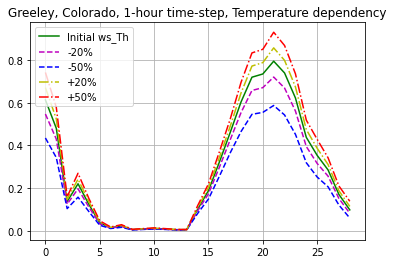

In [5]:
result = run_pm(ws_Th, ws_eah, ws_Rsh, ws_windspeedh,ws_rhh, Rnet_orig_h)
plt.plot(result,'g',label='Initial ws_Th')
result2 = run_pm(ws_Th_m20, ws_eah, ws_Rsh, ws_windspeedh,ws_rhh,Rnet_orig_h)
plt.plot(result2,'m--',label='-20%')
result4 = run_pm(ws_Th_m50, ws_eah, ws_Rsh, ws_windspeedh,ws_rhh, Rnet_orig_h)
plt.plot(result4,'b--',label='-50%')
result1 = run_pm(ws_Th_p20, ws_eah, ws_Rsh, ws_windspeedh,ws_rhh, Rnet_orig_h)
plt.plot(result1,'y-.',label='+20%')
result3 = run_pm(ws_Th_p50, ws_eah, ws_Rsh, ws_windspeedh,ws_rhh, Rnet_orig_h)
plt.plot(result3,'r-.',label='+50%')

plt.legend(loc="upper left")

plt.title("Greeley, Colorado, 1-hour time-step, Temperature dependency")
plt.grid(True)
plt.show()

### windspeed sensitivity

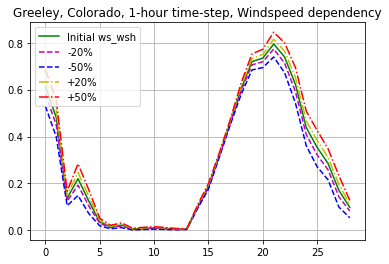

In [6]:
#windspeed impact
ws_wsh_p20 = []
ws_wsh_m20 = []
ws_wsh_p50 = []
ws_wsh_m50 = []
for ws in ws_windspeedh:
    ws_wsh_p20.append(ws + ws * 0.2)
    ws_wsh_m20.append(ws - ws * 0.2)
    ws_wsh_p50.append(ws + ws * 0.5)
    ws_wsh_m50.append(ws - ws * 0.5)

result = run_pm(ws_Th, ws_eah, ws_Rsh, ws_windspeedh,ws_rhh, Rnet_orig_h)
plt.plot(result,'g',label='Initial ws_wsh')
result2 = run_pm(ws_Th, ws_eah, ws_Rsh, ws_wsh_m20,ws_rhh, Rnet_orig_h)
plt.plot(result2,'m--',label='-20%')
result4 = run_pm(ws_Th, ws_eah, ws_Rsh, ws_wsh_m50,ws_rhh, Rnet_orig_h)
plt.plot(result4,'b--',label='-50%')
result1 = run_pm(ws_Th, ws_eah, ws_Rsh, ws_wsh_p20,ws_rhh, Rnet_orig_h)
plt.plot(result1,'y-.',label='+20%')
result3 = run_pm(ws_Th, ws_eah, ws_Rsh, ws_wsh_p50,ws_rhh, Rnet_orig_h)
plt.plot(result3,'r-.',label='+50%')

plt.legend(loc="upper left")

plt.title("Greeley, Colorado, 1-hour time-step, Windspeed dependency")
plt.grid(True)
plt.show()

### Actual vapor pressure/relative humidity

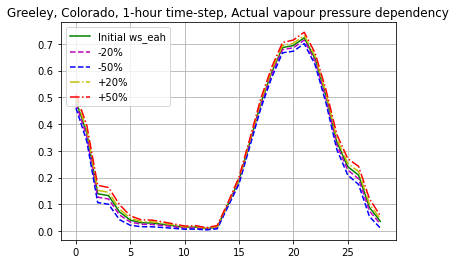

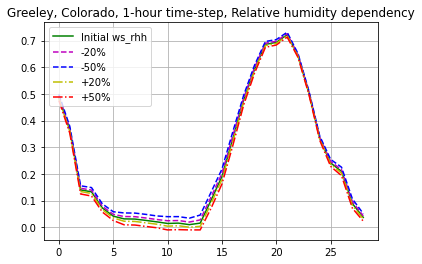

In [7]:
# actual vapour pressure impact
ws_eah_p20 = []
ws_eah_m20 = []
ws_eah_p50 = []
ws_eah_m50 = []
for ea in ws_eah:
    ws_eah_p20.append(ea + ea * 0.2)
    ws_eah_m20.append(ea - ea * 0.2)
    ws_eah_p50.append(ea + ea * 0.5)
    ws_eah_m50.append(ea - ea * 0.5)

ws_rhh = rhh_fun(ws_Th, ws_eah)
ws_rhh_p20 = rhh_fun(ws_Th, ws_eah_p20)
ws_rhh_m20 = rhh_fun(ws_Th, ws_eah_m20)
ws_rhh_p50 = rhh_fun(ws_Th, ws_eah_p50)
ws_rhh_m50 = rhh_fun(ws_Th, ws_eah_m50)

result = run_pm(ws_Th, ws_eah, ws_Rsh, ws_eah,ws_rhh, Rnet_orig_h)
plt.plot(result,'g',label='Initial ws_eah')
result2 = run_pm(ws_Th, ws_eah, ws_Rsh, ws_eah_m20,ws_rhh, Rnet_orig_h)
plt.plot(result2,'m--',label='-20%')
result4 = run_pm(ws_Th, ws_eah, ws_Rsh, ws_eah_m50,ws_rhh, Rnet_orig_h)
plt.plot(result4,'b--',label='-50%')
result1 = run_pm(ws_Th, ws_eah, ws_Rsh, ws_eah_p20,ws_rhh, Rnet_orig_h)
plt.plot(result1,'y-.',label='+20%')
result3 = run_pm(ws_Th, ws_eah, ws_Rsh, ws_eah_p50,ws_rhh, Rnet_orig_h)
plt.plot(result3,'r-.',label='+50%')

plt.legend(loc="upper left")

plt.title("Greeley, Colorado, 1-hour time-step, Actual vapour pressure dependency")
plt.grid(True)
plt.show()

# relative humidity impact
ws_rhh_p20 = []
ws_rhh_m20 = []
ws_rhh_p50 = []
ws_rhh_m50 = []
for rh in ws_rhh:
    ws_rhh_p20.append(rh + rh * 0.2)
    ws_rhh_m20.append(rh - rh * 0.2)
    ws_rhh_p50.append(rh + rh * 0.5)
    ws_rhh_m50.append(rh - rh * 0.5)

result = run_pm(ws_Th, ws_eah, ws_Rsh, ws_eah,ws_rhh, Rnet_orig_h)
plt.plot(result,'g',label='Initial ws_rhh')
result2 = run_pm(ws_Th, ws_eah, ws_Rsh, ws_eah,ws_rhh_m20, Rnet_orig_h)
plt.plot(result2,'m--',label='-20%')
result4 = run_pm(ws_Th, ws_eah, ws_Rsh, ws_eah,ws_rhh_m50, Rnet_orig_h)
plt.plot(result4,'b--',label='-50%')
result1 = run_pm(ws_Th, ws_eah, ws_Rsh, ws_eah,ws_rhh_p20, Rnet_orig_h)
plt.plot(result1,'y-.',label='+20%')
result3 = run_pm(ws_Th, ws_eah, ws_Rsh, ws_eah,ws_rhh_p50, Rnet_orig_h)
plt.plot(result3,'r-.',label='+50%')

plt.legend(loc="upper left")

plt.title("Greeley, Colorado, 1-hour time-step, Relative humidity dependency")
plt.grid(True)
plt.show()


### Rnet sensitivity

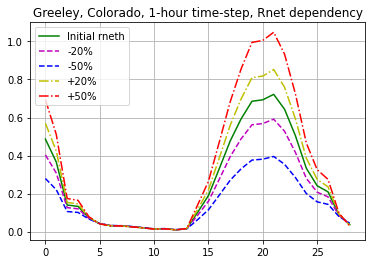

In [8]:
# rnet impact
rneth_p20 = []
rneth_m20 = []
rneth_p50 = []
rneth_m50 = []
for rnet in Rnet_orig_h:
    rneth_p20.append(rnet + rnet * 0.2)
    rneth_m20.append(rnet - rnet * 0.2)
    rneth_p50.append(rnet + rnet * 0.5)
    rneth_m50.append(rnet - rnet * 0.5)

result = run_pm(ws_Th, ws_eah, ws_Rsh, ws_eah,ws_rhh, Rnet_orig_h)
plt.plot(result,'g',label='Initial rneth')
result2 = run_pm(ws_Th, ws_eah, ws_Rsh, ws_eah,ws_rhh, rneth_m20)
plt.plot(result2,'m--',label='-20%')
result4 = run_pm(ws_Th, ws_eah, ws_Rsh, ws_eah,ws_rhh, rneth_m50)
plt.plot(result4,'b--',label='-50%')
result1 = run_pm(ws_Th, ws_eah, ws_Rsh, ws_eah,ws_rhh, rneth_p20)
plt.plot(result1,'y-.',label='+20%')
result3 = run_pm(ws_Th, ws_eah, ws_Rsh, ws_eah,ws_rhh, rneth_p50)
plt.plot(result3,'r-.',label='+50%')

plt.legend(loc="upper left")

plt.title("Greeley, Colorado, 1-hour time-step, Rnet dependency")
plt.grid(True)
plt.show()

### Elevation

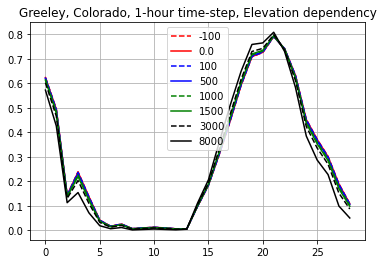

In [9]:
# elevation

dt = 1
n = 30
lai = 2.0
rl = 144
elevation_array = [-100, 0.0, 100, 500, 1000, 1500, 3000, 8000]
colors = ('r--','r', 'b--','b','g--','g','k--','k')
i = 0
for elevation in elevation_array:
    result = run_pm(ws_Th, ws_eah, ws_Rsh, ws_windspeedh,ws_rhh, Rnet_orig_h, height_veg,dt, n,rl,height_ws, height_t, elevation)
    plt.plot(result,colors[i],label=elevation)
    i+=1

plt.legend(loc="upper center")

plt.title("Greeley, Colorado, 1-hour time-step, Elevation dependency")
plt.grid(True)
plt.show()

## Sensitivity to parameters we will study using FPM

### Vegetation height

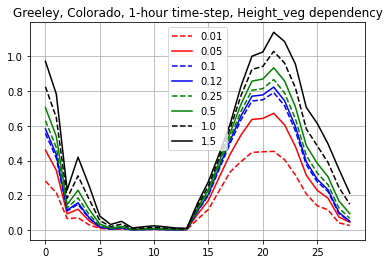

In [10]:
# height vegetation

dt = 1
n = 30
rl = 72
hveg_array = [0.01, 0.05, 0.1, 0.12, 0.25, 0.5, 1.0, 1.5]
colors = ('r--','r', 'b--','b','g--','g','k--','k','m--','m')
i = 0
for height_veg in hveg_array:
    result = run_pm(ws_Th, ws_eah, ws_Rsh, ws_windspeedh,ws_rhh, Rnet_orig_h, height_veg,dt, n,rl,height_ws, height_t, elevation,'full')
    plt.plot(result,colors[i],label=height_veg)
    i+=1

plt.legend(loc="upper center")

plt.title("Greeley, Colorado, 1-hour time-step, Height_veg dependency")
plt.grid(True)
plt.show()



### Stomatal resistance

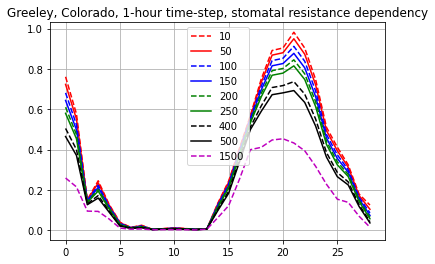

In [11]:
# effective stimatal resistanse

dt = 1
n = 30
rl = 144
height_veg = 0.5
rl_array = [10, 50, 100, 150, 200,250, 400, 500,1500]
colors = ('r--','r', 'b--','b','g--','g','k--','k','m--','m')
i = 0
for rl in rl_array:
    result = run_pm(ws_Th, ws_eah, ws_Rsh, ws_windspeedh,ws_rhh, Rnet_orig_h, height_veg,dt, n,rl,height_ws, height_t, elevation,'full')
    plt.plot(result,colors[i],label=rl)
    i+=1

plt.legend(loc="upper center")

plt.title("Greeley, Colorado, 1-hour time-step, stomatal resistance dependency")
plt.grid(True)
plt.show()

### WS measurements height

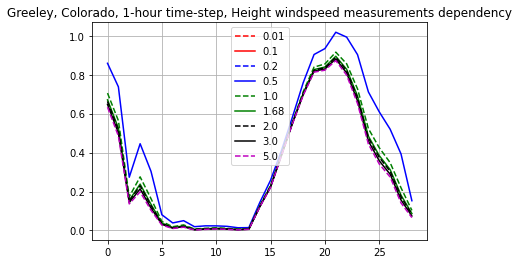

In [12]:
# ws measurements height
dt = 1
n = 30
lai = 2.0
rl = 144
height_ws_array = [0.01, 0.1, 0.2, 0.5, 1.0, 1.68, 2.0, 3.0, 5.0]
colors = ('r--','r', 'b--','b','g--','g','k--','k','m--','m')
i = 0
for height_ws in height_ws_array:
    result = run_pm(ws_Th, ws_eah, ws_Rsh, ws_windspeedh,ws_rhh, Rnet_orig_h, height_veg,dt, n,rl,height_ws, height_t, elevation,'full')
    plt.plot(result,colors[i],label=height_ws)
    i+=1

plt.legend(loc="upper center")

plt.title("Greeley, Colorado, 1-hour time-step, Height windspeed measurements dependency")
plt.grid(True)
plt.show()

### Temperature and humidity measurements height

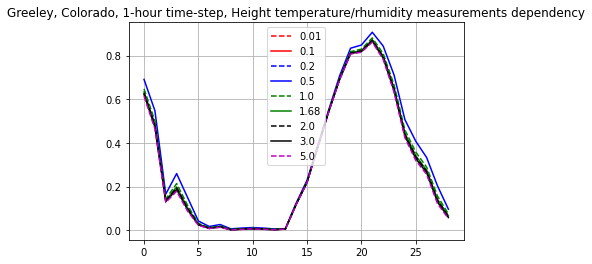

In [13]:
# t measurements height
dt = 1
n = 30
lai = 2.0
rl = 144
height_t_array = [0.01, 0.1, 0.2, 0.5, 1.0, 1.68, 2.0, 3.0, 5.0]
colors = ('r--','r', 'b--','b','g--','g','k--','k','m--','m')
i = 0
for height_t in height_t_array:
    result = run_pm(ws_Th, ws_eah, ws_Rsh, ws_windspeedh,ws_rhh, Rnet_orig_h, height_veg,dt, n,rl,height_ws, height_t, elevation,'full')
    plt.plot(result,colors[i],label=height_t)
    i+=1

plt.legend(loc="upper center")

plt.title("Greeley, Colorado, 1-hour time-step, Height temperature/rhumidity measurements dependency")
plt.grid(True)
plt.show()